# Problem 1

In this part, we implement an estimator for the Jensen-Shannon divergence and one for the Wasserstein distance between two distributions.

In [0]:
# Mount the virtual drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd gdrive/My Drive/Colab\ Notebooks/AaronTP3

/content/gdrive/My Drive/Colab Notebooks/AaronTP3


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from samplers import *
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Density of two distributions')

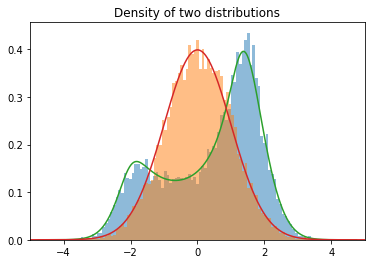

In [0]:
# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))
plt.title("Density of two distributions")

In [0]:
class MLP(nn.Module):
    
    def __init__(self,in_size,out_size,hidden_sizes,use_sigmoid=True):
        super(MLP,self).__init__()
        # cocantenate all the sizes
        sizes = [in_size]+hidden_sizes+[out_size]
        
        # Build the network structure
        layers = []
        for i,(a,b) in enumerate(zip(sizes[:-1],sizes[1:])):
            layers.append(nn.Linear(a,b))
            if i == len(sizes)-2:
                if use_sigmoid:
                    layers.append(self.output_activation())
            else:
                layers.append(nn.ReLU())

        self.fc = nn.Sequential(*layers)
    
    def output_activation(self):
        return nn.Sigmoid()
    def forward(self,input_):
        return self.fc(input_)

## 1.1)

We implement a function that estimates the Jensen Shannon Divergence between two distributions $p$ and $q$, using an optimal discriminator $D$.  This divergence is defined as $D_{JS}(p||q)=\frac{1}{2}D_{KL}(p||r) + \frac{1}{2}D_{KL}(q||r)$ where $r(x)=\dfrac{p+q}{2}$. Hence, the objective function that the neural network should optimize is:
    \begin{align*}
        \arg\max_{\theta}\left\{ \log2 + \dfrac{1}{2}\mathbf{E}_{x\sim p}[\log(D_\theta (x))] + \dfrac{1}{2}\mathbf{E}_{y\sim q}\log(1-D_\theta (y))]\right\}
    \end{align*}


In [0]:
def estimate_JSD(D,p_batch,q_batch,*args,**kwargs):
    # do a forward throught batches generated from q and p distributions
    q_forward = D(q_batch)
    p_forward = D(p_batch)
    
    # calculate the JSD Estimate 
    return np.log(2) + torch.mean(torch.log(p_forward) + torch.log(1-q_forward))/2


## 1.2)

We implement a function that estimates the Wasserstein distance between two distributions $p$ and $q$, using an optimal discriminator $D$. We exploit the Kantorovich-Rubinstein duality and implement gradient penalty to ensure the function is 1-Lipschitz.  Hence, the objective that the network should optimize is :
    \begin{align*}
    \arg\max_\theta \mathbf{E}_{x\sim p}[T_\theta(x)]-\mathbf{E}_{y\sim q}[T_\theta(y)] - \lambda \mathbf{E}_{z\sim r} (||\nabla_z T_\theta(z)||_2 - 1)^2.
    \end{align*}
    $r$ is the distribution over $z=ax+(1-a)y$, where $x\sim p$, $y\sim q$ and $a\sim U[0,1]$. It is recommended that $\lambda \geq 10$.

In [0]:
def estimate_WD(D,p_batch,q_batch,lambda_,with_grad = True):
    # do a forward throught batches generated from q and p distributions
    q_forward = D(q_batch)
    p_forward = D(p_batch)
    
    if with_grad:
        # calculate the gradient penalty
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        a = torch.empty(p_forward.size(0),1).uniform_(0, 1).to(device)
        a.expand(p_forward.size(0),p_forward.size(1))
        z_batch = (a*p_batch +(1-a)*q_batch).requires_grad_(True)
        z_forward = D(z_batch)

        grads = torch.autograd.grad(z_forward,z_batch,grad_outputs=torch.ones_like(z_forward),create_graph=True,only_inputs=True)
        norm_2 = (torch.norm(grads[0],p=2,dim=1)-1)**2

        return torch.mean(p_forward - q_forward - lambda_*norm_2)
    else:
        return torch.mean(p_forward - q_forward)

## 1.3) 

Let $Z\sim U[0,1]$ be a random variable with a uniform distribution. Let $p$ be the distribution of (0, $Z$) and $q_\theta$ be the distribution of ($\phi, Z$), where $\phi$ is a parameter.

Let us plot the estimated JSD and the WD for $\phi \in [-1,1]$ with intervals of 0.1 (i.e. 21 points), where the x-axis is the value of $\phi$ and the y-axis is our estimate.

In [0]:
def train(p,q,criteria,progress_bar=None,input_size=2,output_size = 1,lr=1e-3,lambda_=15,hidden_sizes = [64,64,64],use_sigmoid=True ,n_epochs=100):

    D = MLP(input_size,output_size,hidden_sizes,use_sigmoid=use_sigmoid)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    D = D.to(device)
    optimizer = optim.Adam(D.parameters(),lr=lr)
    
    pbar_set = True
    if progress_bar is None:
        pbar_set = False
        progress_bar = epochs = tqdm(range(n_epochs))
    else:
        epochs = range(n_epochs)
    for epoch in epochs:

        q_batch = torch.tensor(next(q)).float().to(device)
        p_batch = torch.tensor(next(p)).float().to(device)
        
        optimizer.zero_grad()
        loss = -criteria(D,p_batch,q_batch,lambda_)
        loss.backward()
        optimizer.step()
        
        
        if pbar_set:
            msg = f"Theta: {q_batch[0][0]:.2} "
        else:
            msg = ""
        progress_bar.set_description(msg+f"Epoch: {epoch}/{n_epochs} Loss: {loss:.4}")

    return D, -criteria(D,p_batch,q_batch,lambda_,with_grad = False)

In [0]:
p3 = distribution1(0,batch_size=512)
q3 = lambda theta: distribution1(theta,batch_size=512)
thetas = np.linspace(-1,1,21)

In [0]:
jsd_estimates = []

pbar = tqdm(thetas)
for i,theta in enumerate(pbar):
    q3_theta = q3(theta)
    D,loss = train(p3,q3_theta,estimate_JSD,progress_bar=pbar,n_epochs=1000)
    jsd_estimates.append(-loss.cpu().data.numpy())

Theta: 1.0 Epoch: 999/1000 Loss: -0.6931: 100%|██████████| 21/21 [02:28<00:00,  6.89s/it]


Text(0, 0.5, 'JSD Estimates')

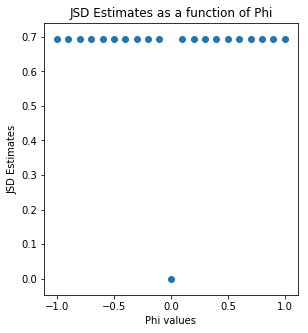

In [0]:
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,2,2)
plt.scatter(thetas,jsd_estimates)
plt.title("JSD Estimates as a function of Phi")
plt.xlabel("Phi values")
plt.ylabel("JSD Estimates")

The Jensen-Shannon divergence estimation that we observe in the plot is given by:

 - $D_{JS}(p||q) = log(2) \approx 0.69314$, if $\phi \neq 0$
 -  $D_{JS}(p||q) = 0 $, if $\phi = 0$ 
 
 This is because the two distributions $p$ and $q_\theta$ are disjoint for all values of $\phi$ except for $\phi$ equal to zero.
 
 In fact, we proved in the homework 3 that the Jensen Shannon divergence is equal to $log(2)$ when the 2 densities are non-overlapping. Here they are not overlapping for $\phi \neq 0$. For $\phi = 0$, they are the same: $p = q_\theta$, which makes that the divergence is zero. 
 
 This represents a major problem when we train using this density, the gradient would be zero everywhere and wouldn't be informative. The divergence itself isn't informative because it doesn't tell us how close we are from the optimal value of $\phi$. This discontinuity (jump) makes us explore other distances such as the Wasserstein Distance.

In [0]:
wd_estimates = []

pbar = tqdm(thetas)
for i,theta in enumerate(pbar):
    q3_theta = q3(theta)
    # for WD we don't use the sigmoid on the output layer
    D,loss = train(p3,q3_theta,estimate_WD,progress_bar=pbar,n_epochs=1000,use_sigmoid=False)
    wd_estimates.append(-loss.cpu().data.numpy())

Theta: 1.0 Epoch: 999/1000 Loss: -1.017: 100%|██████████| 21/21 [02:52<00:00,  8.09s/it]


Text(0, 0.5, 'WD Estimates')

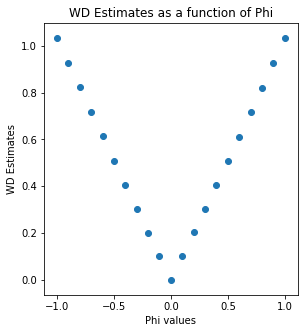

In [0]:
plt.rcParams["figure.figsize"] = (10,5)

plt.subplot(1,2,2)
plt.scatter(thetas,wd_estimates)
plt.title("WD Estimates as a function of Phi")
plt.xlabel("Phi values")
plt.ylabel("WD Estimates")

The Wasserstein Distance estimation that we observe in the plot is given by:

 - $W(p||q) = | \phi | $,   $\forall \phi$ 
 
The two distributions $p$ and $q_\theta$ are disjoint for all values of $\phi$ except for $\phi$ equal to zero. However, the gradient of the Wasserstein Distance with respect to $\phi$ isn't null everywhere in contrast with the Jensen Shanon divergence. The gradient is equal to 1 or -1 depending on whether we take positive or negative values of $\phi$. This information is useful because it tells us the direction that would lead us to the optimal $\phi$, which is $\phi=0$ for which the two distributions are equal.
 

## 1.4) 

Let $f_0$ be the density of a 1-dimensional standard Gaussian, and $f_1$ be the unknown density function of *distribution4*.  Let us train a discriminator $D_\theta$ by maximizing the value function 
    $$E_{x\sim f_1}[\log D_\theta(x)] + E_{y\sim f_0}[\log (1-D_\theta(y))]$$
    We estimate the density $f_1$ by using  ${f_0(x){D(x)}/(1-D(x))}$ as proved in Question 5 in the theory part.
    
    
  

In [0]:
# JSD
input_size = 1
p = distribution4(batch_size=512)
q = distribution3(batch_size=512)

D,_ = train(p,q,estimate_JSD,input_size=input_size,n_epochs=4000,lr=1e-3)

Epoch: 3999/4000 Loss: -0.1105: 100%|██████████| 4000/4000 [00:24<00:00, 160.63it/s]


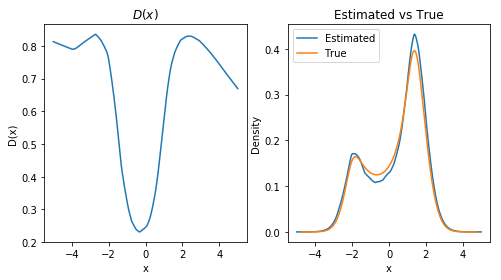

In [0]:
# JSD
r_jsd = np.array(D(torch.tensor(xx).reshape(-1,1).float().cuda()).tolist()).ravel()
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r_jsd)
plt.title(r'$D(x)$')
plt.ylabel("D(x)")
plt.xlabel("x")

estimate = (N(xx)*r_jsd/(1-r_jsd))

plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')
plt.ylabel("Density")
plt.xlabel("x")

plt.show()

We did plot above the discriminator output and the estimated density (using the script *density\_estimation.py*). We notice that the estimated distribution is very close to the true distribution, thus the procedure used here and proved in the theory part is efficient. 